In [2]:
import os
import sys
import warnings
import pandas as pd
from tqdm.notebook import tqdm

base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
print(f"base_path: {base_path}")
sys.path.append(base_path)

import express.config as config
from express.databases import SQLiteDatabase
from express.datasets import PressingDataset
from express.utils import add_names

base_path: c:\Users\mirun\24_winter\press\sr-press


In [3]:
TRAIN_DB_PATH = os.path.join(base_path, "stores/train_database.sqlite")
TEST_DB_PATH = os.path.join(base_path, "stores/test_database.sqlite")

train_db = SQLiteDatabase(TRAIN_DB_PATH)
test_db = SQLiteDatabase(TEST_DB_PATH)

print("train_db:", train_db)
print("test_db:", test_db)
game_id = 3895302

df_actions = add_names(train_db.actions(game_id))
#display max columns
pd.set_option('display.max_columns', None)

train_db: <express.databases.sqlite.SQLiteDatabase object at 0x00000269A937EDE0>
test_db: <express.databases.sqlite.SQLiteDatabase object at 0x00000269AAAC84A0>


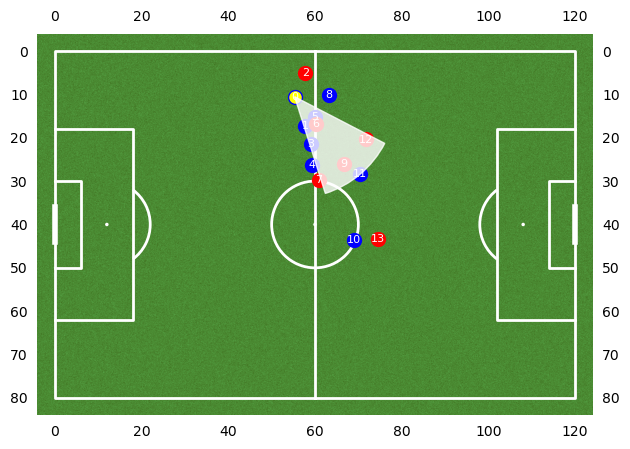

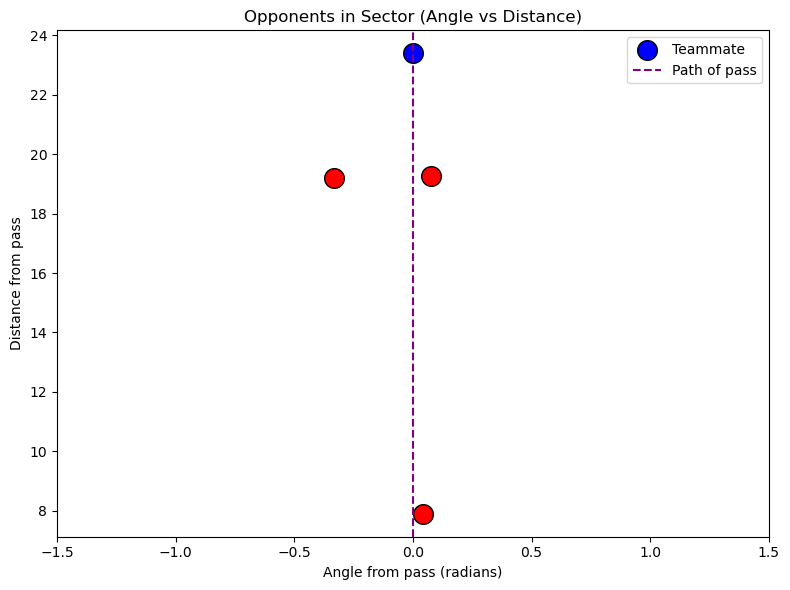

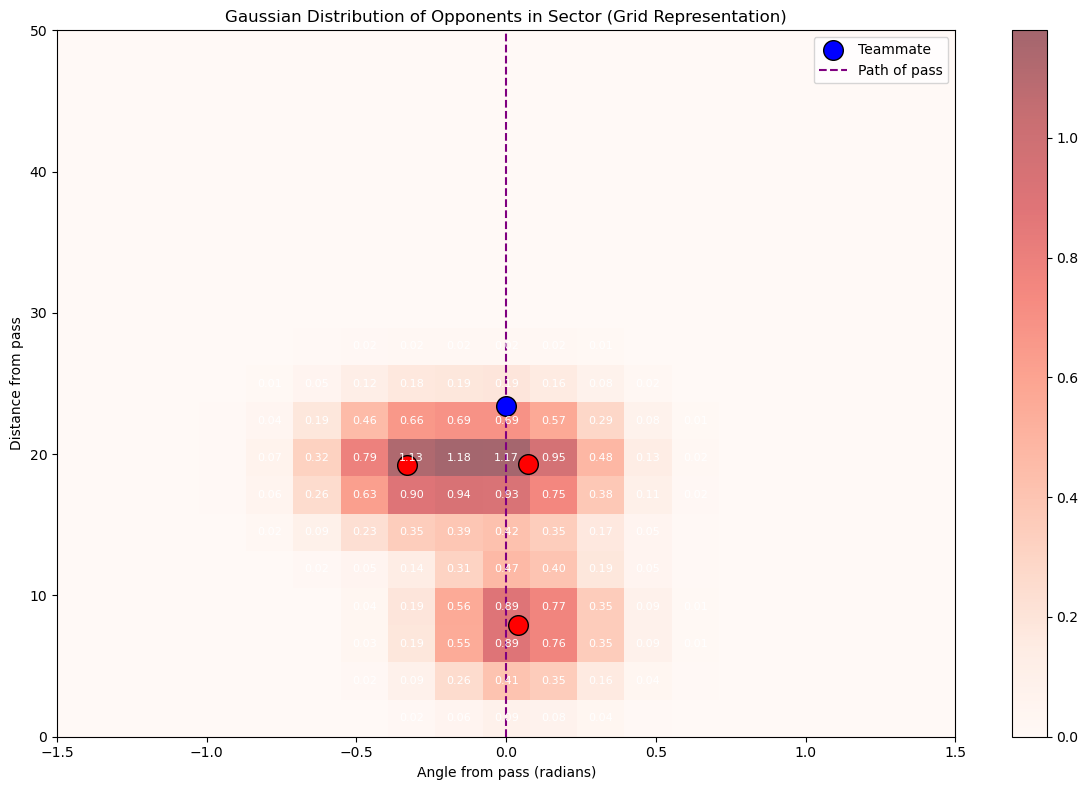

보라색 선을 지나는 셀들의 값의 합: 6.18


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
from mplsoccer import Pitch

class SectorAnalysis:
    def __init__(self, freeze_frame, angle=45, player_idx=0,visualize=False):
        self.freeze_frame = freeze_frame
        self.angle = angle
        self.actor = next(player for player in freeze_frame if player['actor'])
        self.teammate = freeze_frame[player_idx]  
        self.visualize = visualize
        self.opponents_in_sector = []
        self.Z = None

    def draw_pitch(self):
        if not self.visualize:
            return
        pitch = Pitch(pitch_type='statsbomb', label=True, pitch_color='grass', line_color='white')
        fig, ax = pitch.draw()
        
        # 각 플레이어 표시
        for idx, player in enumerate(self.freeze_frame):
            x, y = player['x'], player['y']
            if player['actor']:
                pitch.scatter(x, y, s=100, c='yellow', edgecolors='blue', marker='o', ax=ax)  # 공 소유자 강조
                ax.text(x, y, str(idx), fontsize=8, color='white', ha='center', va='center')  # 인덱스 레이블 추가
            elif player['teammate']:
                pitch.scatter(x, y, s=100, c='blue', marker='o', ax=ax)  # 팀원 표시
                ax.text(x, y, str(idx), fontsize=8, color='white', ha='center', va='center')  # 인덱스 레이블 추가
            else:
                pitch.scatter(x, y, s=100, c='red', marker='o', ax=ax)  # 상대 선수 표시
                ax.text(x, y, str(idx), fontsize=8, color='white', ha='center', va='center')  # 인덱스 레이블 추가

        # 부채꼴 그리기
        actor_x, actor_y = self.actor['x'], self.actor['y']
        teammate_x, teammate_y = self.teammate['x'], self.teammate['y']
        distance = ((teammate_x - actor_x) ** 2 + (teammate_y - actor_y) ** 2) ** 0.5
        direction_angle = np.degrees(np.arctan2(teammate_y - actor_y, teammate_x - actor_x))
        start_angle = direction_angle - self.angle / 2
        end_angle = direction_angle + self.angle / 2

        wedge = Wedge(center=(actor_x, actor_y), r=distance, theta1=start_angle, theta2=end_angle,
                      color="white", alpha=0.8, edgecolor="black")
        ax.add_patch(wedge)

        plt.show()

    def calculate_opponents_in_sector(self):
        # 부채꼴 내 상대 선수 필터링 및 거리와 각도 계산
        actor_x, actor_y = self.actor['x'], self.actor['y']
        baseline_angle = np.arctan2(self.teammate['y'] - actor_y, self.teammate['x'] - actor_x)
        distance = ((self.teammate['x'] - actor_x) ** 2 + (self.teammate['y'] - actor_y) ** 2) ** 0.5

        for player in self.freeze_frame:
            if not player['teammate']:  # 상대 선수만 필터링
                px, py = player['x'], player['y']
                angle_to_player = np.arctan2(py - actor_y, px - actor_x)
                angle_diff = angle_to_player - baseline_angle
                angle_diff = (angle_diff + np.pi) % (2 * np.pi) - np.pi

                # 부채꼴 안에 있는 선수 필터링
                if abs(angle_diff) <= np.radians(self.angle / 2):
                    dist_to_player = np.sqrt((px - actor_x) ** 2 + (py - actor_y) ** 2)
                    if dist_to_player <= distance:
                        self.opponents_in_sector.append((angle_diff, dist_to_player))

    def visualize_opponents(self):
        if not self.visualize:
            return  
        # 부채꼴 안에 있는 상대 선수들의 위치를 시각화
        fig, ax = plt.subplots(figsize=(8, 6))
        
        distance = ((self.teammate['x'] - self.actor['x']) ** 2 + (self.teammate['y'] - self.actor['y']) ** 2) ** 0.5

        # teammate는 중앙(0, 거리)로 표시
        ax.scatter(0, distance, c='blue', s=200, label="Teammate", edgecolor='black')

        # opponent들을 angle_diff와 거리에 따라 표시
        for angle, dist in self.opponents_in_sector:
            ax.scatter(angle, dist, c='red', s=200, edgecolor='black')
            

        # 축 및 제목 설정
        ax.axvline(0, color='purple', linestyle='--', label='Path of pass')
        ax.set_xlim(-1.5, 1.5)  # x축을 동적으로 설정
        ax.set_xlabel('Angle from pass (radians)')
        ax.set_ylabel('Distance from pass')
        ax.set_title('Opponents in Sector (Angle vs Distance)')
        ax.legend()
        plt.tight_layout()
        plt.show()

    def calculate_gaussian_distribution(self, sigma_x=0.2, sigma_y=3):
        # 각도와 거리 데이터를 기반으로 가우시안 분포 계산 후 그리드에 누적
        angles = np.array([angle for angle, _ in self.opponents_in_sector])
        distances = np.array([dist for _, dist in self.opponents_in_sector])

        x_bins = np.linspace(-1.5, 1.5, 20)
        y_bins = np.linspace(0, 50, 20)
        Z = np.zeros((len(y_bins) - 1, len(x_bins) - 1))


        # 가우시안 분포 계산
        for angle, dist in zip(angles, distances):
            for i in range(len(x_bins) - 1):
                for j in range(len(y_bins) - 1):
                    x_center = (x_bins[i] + x_bins[i + 1]) / 2
                    y_center = (y_bins[j] + y_bins[j + 1]) / 2
                    gaussian = np.exp(-(((x_center - angle) ** 2) / (2 * sigma_x ** 2) +
                                        ((y_center - dist) ** 2) / (2 * sigma_y ** 2)))
                    Z[j, i] += gaussian

        self.Z = Z
        self.x_bins = x_bins
        self.y_bins = y_bins

    def visualize_density(self):
        if not self.visualize:
            return 
        fig, ax = plt.subplots(figsize=(12, 8))
        c = ax.pcolormesh(self.x_bins, self.y_bins, self.Z, cmap='Reds', shading='auto', alpha=0.6)
        fig.colorbar(c, ax=ax)

        # Opponents와 Teammate 시각화
        ax.scatter(0, ((self.teammate['x'] - self.actor['x'])**2 + (self.teammate['y'] - self.actor['y'])**2)**0.5,
                   c='blue', s=200, label="Teammate", edgecolor='black', zorder=2)
        for angle, dist in self.opponents_in_sector:
            ax.scatter(angle, dist, c='red', s=200, edgecolor='black', zorder=2)

        # 각 셀의 값을 텍스트로 표시
        for i in range(len(self.x_bins) - 1):
            for j in range(len(self.y_bins) - 1):
                x_center = (self.x_bins[i] + self.x_bins[i + 1]) / 2
                y_center = (self.y_bins[j] + self.y_bins[j + 1]) / 2
                value = self.Z[j, i]
                if value > 0.01:
                    ax.text(x_center, y_center, f'{value:.2f}', color='white', ha='center', va='center', fontsize=8)

        ax.axvline(0, color='purple', linestyle='--', label='Path of pass', zorder=1)
        ax.set_xlim(-1.5, 1.5)
        ax.set_xlabel('Angle from pass (radians)')
        ax.set_ylabel('Distance from pass')
        ax.set_title('Gaussian Distribution of Opponents in Sector (Grid Representation)')
        ax.legend()
        plt.tight_layout()
        plt.show()

    def get_column_sum(self):
        closest_index = np.abs(self.x_bins - 0).argmin()
        column_sum = self.Z[:, closest_index].sum()
        print(f"보라색 선을 지나는 셀들의 값의 합: {column_sum:.2f}")
        return column_sum

if __name__ == "__main__":
    freeze_frame = df_actions.loc[3895302, "freeze_frame_360"][30]

    sector_analysis = SectorAnalysis(freeze_frame,angle=45, player_idx=8, visualize=True)
    sector_analysis.draw_pitch()
    sector_analysis.calculate_opponents_in_sector()
    sector_analysis.visualize_opponents()
    sector_analysis.calculate_gaussian_distribution(sigma_x=0.2, sigma_y=3)
    sector_analysis.visualize_density()
    sector_analysis.get_column_sum()


In [32]:
teammate = freeze_frame[8]  # 4번째 플레이어 예시 (인덱스 3)
teammate_x, teammate_y = teammate['x'], teammate['y']
teammate

{'teammate': True,
 'actor': False,
 'keeper': False,
 'x': 40.49423595174101,
 'y': 13.593196318023473}